# Изучение поведения юзеров приложения по продаже продуктов

Стартап по продаже продуктов питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

[Изучите воронку продаж.](#Воронка-продаж-4) Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

[После этого исследуйте результаты A/A/B-эксперимента.](#Изучение-результатов-эксперимента-5) Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.


---
Краткие выводы: 

- Необходимо доработать верстку главного экрана. Большое количество пользователей отваливается на этом шаге.
- Изменение шрифтов во всем приложении никак не сказалось на пользовательском опыте и продажах.
---

Описание данных:

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
---

## Установка, обновление и импорт библиотек

In [35]:
!pip install seaborn --upgrade

In [36]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests


## Загрузка и предобработка данных

In [37]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [38]:
display(df.head())
print(len(df))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


244126


In [39]:
df = df.rename(columns={'EventName':'event_name', 
                   'DeviceIDHash':'user_id', 
                   'EventTimestamp':'event_time', 
                   'ExpId':'exp_id'}) 

In [40]:
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
df['date'] = df['event_time'].dt.date
df['date'] = pd.to_datetime(df['date'])

Переименовали столбцы и привели формат даты и времени к верному. Создали новый столбец с датой.

In [41]:
df.tail()

,event_name,user_id,event_time,exp_id,date
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07
244125,OffersScreenAppear,5746969938801999050,2019-08-07 21:15:17,246,2019-08-07


In [42]:
len(df[df.duplicated()])

413

In [43]:
len(df[df.duplicated()]) / len(df) * 100

0.16917493425526162

In [44]:
df = df.drop_duplicates()

Дубликатов в данных менее 0.2% удалим их и не заметим. Появиться они могли из-за мелких сбоев в системе сбора информации. 

In [45]:
# Проверка на попадание пользователей во все группы
orders_in_two_groups = (pd.pivot_table(df, 
                                      values='event_name', 
                                      index=['user_id'],
                                      columns=['exp_id'], 
                                      aggfunc='count')
                          .dropna()
                          .reset_index()
                       )

orders_in_two_groups.columns = ['user_id', '246', '247', '248']

display(orders_in_two_groups.head())
print('Количество пользователей попавших во все группы: ', len(orders_in_two_groups))

,user_id,246,247,248


Количество пользователей попавших во все группы:  0


## Анализ данных

In [46]:
print(df.nunique())
print('Всего наблюдений:', len(df))

event_name         5
user_id         7551
event_time    176654
exp_id             3
date              14
dtype: int64
Всего наблюдений: 243713


Всего наблюдений 244126. В логах 5 событий на 7551 пользователя из трех групп. Данные за две недели.

In [47]:
len(df) / df['user_id'].nunique()

32.27559263673685

В среднем 32 события на пользователя.

### Период исследования

In [48]:
print('Начало периода: {}'.format(df['event_time'].min()))
print('Конец периода: {}'.format(df['event_time'].max()))

Начало периода: 2019-07-25 04:43:36
Конец периода: 2019-08-07 21:15:17


Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

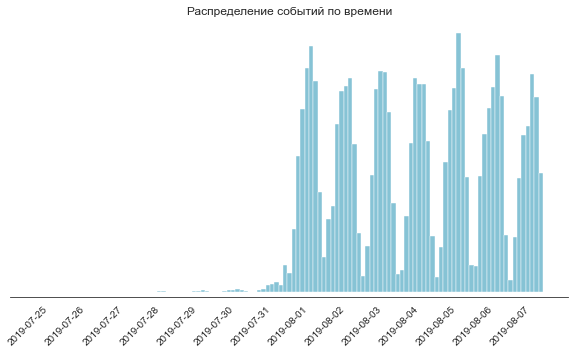

In [49]:
sns.set_style("white")

fig = plt.figure(figsize =(10, 5))

ax = sns.histplot(data=df, x='event_time', color='#5EAFC7')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))

ax.tick_params(axis='both', which='both', labelsize=10, labelleft=False, labelrotation=45)
ax.set_xticks(df['date'].unique())

plt.xlabel('')
plt.ylabel('')
plt.title('Распределение событий по времени')
plt.show()

Действительно, данных до 1 августа явно не хватает. Откинем их и оставим только данные с 2019-08-01 по 2019-08-07.

In [50]:
df_full = df.loc[df['date'] >= datetime(2019,8,1)]

In [51]:
print('Откинули:')
print('{} наблюдений'.format(len(df) - len(df_full)))
print('{} пользователей'.format(df['user_id'].nunique() - df_full['user_id'].nunique()))

Откинули:
2826 наблюдений
17 пользователей


In [52]:
exp_groups = df.groupby('exp_id').agg(count=('user_id','count')).reset_index()

In [53]:
exp_groups 

,exp_id,count
0,246,80181
1,247,77950
2,248,85582


Данные есть по всем трем группам теста.

### События и пользователи

In [54]:
event_count = (df.groupby('event_name')
                .agg(count_events=('user_id','count'), 
                     count_users=('user_id','nunique'))
                .sort_values(by='count_users', ascending=False)
                .reset_index()
               )
event_count['perc_all_users'] = (event_count['count_users'] / df_full['user_id'].nunique()).map('{:.2%}'.format)

In [55]:
event_count

,event_name,count_events,count_users,perc_all_users
0,MainScreenAppear,119101,7439,98.74%
1,OffersScreenAppear,46808,4613,61.23%
2,CartScreenAppear,42668,3749,49.76%
3,PaymentScreenSuccessful,34118,3547,47.08%
4,Tutorial,1018,847,11.24%


При сортировке по пользователям, события выстраиваются в последовательную цепочку, за исключением Обучения. Скорее всего, большинство пользователей даже не видят страницу Обучения. 1,2% пользователей не видели главную страницу, похоже они не прошли обучение. 

## Воронка продаж 

In [56]:
event_funnel = event_count[0:4]
event_funnel = event_funnel[['event_name', 'count_users']]

In [57]:
event_funnel['perc_from_last_event'] = (1 - abs(event_funnel['count_users'].pct_change()).fillna(0)).map('{:.2%}'.format)

In [58]:
event_funnel

,event_name,count_users,perc_from_last_event
0,MainScreenAppear,7439,100.00%
1,OffersScreenAppear,4613,62.01%
2,CartScreenAppear,3749,81.27%
3,PaymentScreenSuccessful,3547,94.61%


В воронке оставили 4 события. Обучение слишком сильно выпадает из воронки, с ним необходимо разобраться отдельно. Самое большое падение происходит на шаге просмотра экрана Предложений. Только 62% пользователей увидевших Главный экран, видят Предложения. Необходимо доработать верстку главного экрана, чтобы повысить долю пользователей увидевших экран Предложения. 81% пользователей, увидевших экран Предложения, добавляют товар в корзину и просматривают ее. И почти все пользователи - 94%, удачно совершают покупку после просмотра экрана с Корзиной. 

In [59]:
print('{:.2%}'.format(event_funnel['count_users'][3] / event_funnel['count_users'][0]))

47.68%


Конверсия составила почти 48%. Вот это результат! Почти каждый второй пользователь, который увидел стартовый экран, становится покупателем.

### Диаграмма воронки

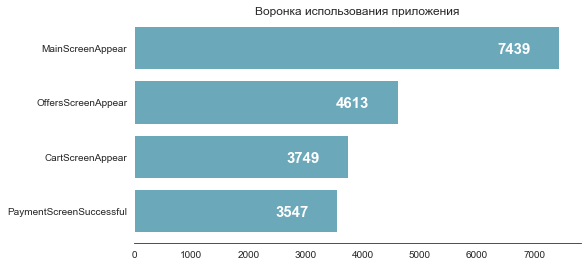

In [60]:
sns.set_style("white")

fig = plt.figure(figsize =(8, 4))

ax = sns.barplot(data=event_funnel, y='event_name', x='count_users', color='#5EAFC7')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))

# Подпишем бары значениями
for i in ax.patches:
    # Добавим количество
    ax.text(i.get_width()-500, i.get_y()+0.5, int(i.get_width()), fontsize=15, color='white', fontweight='bold', ha='right')
plt.xlabel('')
plt.ylabel('')
plt.title('Воронка использования приложения')
plt.show()

Наглядно видно большое падение после просмотра Главного экрана.

## Изучение результатов эксперимента

### Количество пользователей в каждой группе

In [61]:
exp_groups

,exp_id,count
0,246,80181
1,247,77950
2,248,85582


In [62]:
# Срезы данных по каждой группе занесем в отдельные переменные
exp_group_246 = df[df['exp_id']==246]
exp_group_247 = df[df['exp_id']==247]
exp_group_246_247 = df[df['exp_id']!=248]
exp_group_248 = df[df['exp_id']==248]

In [63]:
# Посчитаем пользователей на каждом событии по группам
events_246 = (exp_group_246.groupby('event_name')
              .agg(count_users=('user_id', 'nunique'))
              .sort_values(by='count_users', ascending=False)
              .reset_index()
             )
events_247 = (exp_group_247.groupby('event_name')
              .agg(count_users=('user_id', 'nunique'))
              .sort_values(by='count_users', ascending=False)
              .reset_index()
             )
events_246_247 = (exp_group_246_247.groupby('event_name')
              .agg(count_users=('user_id', 'nunique'))
              .sort_values(by='count_users', ascending=False)
              .reset_index()
             )
events_248 = (exp_group_248.groupby('event_name')
              .agg(count_users=('user_id', 'nunique'))
              .sort_values(by='count_users', ascending=False)
              .reset_index()
             )

# Добавим доли от всех пользователей группы
events_246['perc_of_all'] = (events_246['count_users'] / exp_group_246['user_id'].nunique()).map('{:.2%}'.format)
events_247['perc_of_all'] = (events_247['count_users'] / exp_group_247['user_id'].nunique()).map('{:.2%}'.format)
events_246_247['perc_of_all'] = (events_246_247['count_users'] / exp_group_246_247['user_id'].nunique()).map('{:.2%}'.format)
events_248['perc_of_all'] = (events_248['count_users'] / exp_group_248['user_id'].nunique()).map('{:.2%}'.format)

In [64]:
print('Группа 246:')
display(events_246)
print('--------------------------------------------')
print('Группа 247:')
display(events_247)
print('--------------------------------------------')
print('Объединенные группы 246 и 247:')
display(events_246_247)
print('--------------------------------------------')
print('Группа 248:')
display(events_248)

Группа 246:


,event_name,count_users,perc_of_all
0,MainScreenAppear,2456,98.67%
1,OffersScreenAppear,1545,62.07%
2,CartScreenAppear,1270,51.02%
3,PaymentScreenSuccessful,1202,48.29%
4,Tutorial,279,11.21%


--------------------------------------------
Группа 247:


,event_name,count_users,perc_of_all
0,MainScreenAppear,2482,98.49%
1,OffersScreenAppear,1530,60.71%
2,CartScreenAppear,1240,49.21%
3,PaymentScreenSuccessful,1160,46.03%
4,Tutorial,286,11.35%


--------------------------------------------
Объединенные группы 246 и 247:


,event_name,count_users,perc_of_all
0,MainScreenAppear,4938,98.58%
1,OffersScreenAppear,3075,61.39%
2,CartScreenAppear,2510,50.11%
3,PaymentScreenSuccessful,2362,47.16%
4,Tutorial,565,11.28%


--------------------------------------------
Группа 248:


,event_name,count_users,perc_of_all
0,MainScreenAppear,2501,98.39%
1,OffersScreenAppear,1538,60.50%
2,CartScreenAppear,1239,48.74%
3,PaymentScreenSuccessful,1185,46.62%
4,Tutorial,282,11.09%


На первый взгляд, различий нет. Проверим гипотезу с помощью z-теста. 

### Гипотеза H<sub>0</sub> -  доли пользователей, после проведения А/А теста, на каждом шаге воронки, равны

In [65]:
def ztest_bonf_corr(event_1gr, event_2gr, exp_group_1, exp_group_2):
# Зададим функцию подсчета p-value и коррекции уровня значимости.
# Выведем готовые значения и ответы.
    pvalues = []
    for i in range(0, len(event_count)):
        stat, pval = proportions_ztest([event_1gr['count_users'][i], event_2gr['count_users'][i]],
                                       [exp_group_1['user_id'].nunique(), exp_group_2['user_id'].nunique()])
        pvalues.append(pval)

    reject, p_value_corrected, sidak_corr, bonf_corr = multipletests(pvalues, alpha=0.05, method='holm-sidak')

    print('Скорректированное альфа значение:', bonf_corr)
    print('-----------------------------------------------------------------------------')
    for i in range(0, len(p_value_corrected)):
        print('Гипотеза о равенстве долей в событии', event_count['event_name'][i])
        print('p-значение:', p_value_corrected[i])
        if p_value_corrected[i] < bonf_corr:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('-----------------------------------------------------------------------------')

Не получилось отвергнуть гипотезу H<sub>0</sub> о равенстве долей A/A теста (246 и 247 группы). Разбиение на группы работает корректно.

### Гипотеза H<sub>0</sub> - доли пользователей, после проведения А/B теста, на каждом шаге воронки равны

#### Группы 246 и 248

In [66]:
ztest_bonf_corr(events_246, events_248, exp_group_246, exp_group_248)

Скорректированное альфа значение: 0.01
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии MainScreenAppear
p-значение: 0.6557877371364028
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии OffersScreenAppear
p-значение: 0.6557877371364028
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии CartScreenAppear
p-значение: 0.4268260466067505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии PaymentScreenSuccessful
p-значение: 0.6557877371364028
Не получилось отвергнуть нулевую гипотезу, нет оснований считать д

Не получается отвергнуть H<sub>0</sub> - статистически значимых различий долей нет.

#### Группы 247 и 248

In [67]:
ztest_bonf_corr(events_247, events_248, exp_group_247, exp_group_248)

Скорректированное альфа значение: 0.01
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии MainScreenAppear
p-значение: 0.9964505915634092
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии OffersScreenAppear
p-значение: 0.9964505915634092
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии CartScreenAppear
p-значение: 0.9964505915634092
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии PaymentScreenSuccessful
p-значение: 0.9964505915634092
Не получилось отвергнуть нулевую гипотезу, нет оснований считать д

Тот же результат, что и с первой контрольной группой. Не получается отвергнуть H<sub>0</sub> - статистически значимых различий в долях нет.

#### Объединенные контрольные группы и 248

In [68]:
ztest_bonf_corr(events_246_247, events_248, exp_group_246_247, exp_group_248)

Скорректированное альфа значение: 0.01
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии MainScreenAppear
p-значение: 0.9121255488945333
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии OffersScreenAppear
p-значение: 0.9121255488945333
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии CartScreenAppear
p-значение: 0.7795665653783019
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
Гипотеза о равенстве долей в событии PaymentScreenSuccessful
p-значение: 0.9121255488945333
Не получилось отвергнуть нулевую гипотезу, нет оснований считать д

## Выводы

Всего наблюдений 244126. В логах 5 событий на 7551 пользователя из трех групп. Данные за две недели.
В среднем 32 события на пользователя.
Данных до 1 августа не хватает. Откинем их и оставим только данные за одну неделю - с 2019-08-01 по 2019-08-07.

При сортировке по пользователям, события выстраиваются в последовательную цепочку, за исключением Обучения. 
Скорее всего, большинство пользователей даже не видят страницу Обучения. 
1,2% пользователей не видели главную страницу, похоже они не прошли обучение.

В воронке оставили 4 события. Самое большое падение происходит на шаге просмотра экрана Предложений. Только 62% пользователей увидевших Главный экран, видят Предложения. <b>Необходимо доработать верстку главного экрана, чтобы повысить долю пользователей увидевших экран Предложения.</b> 81% пользователей, увидевших экран Предложения, добавляют товар в корзину и просматривают ее. И почти все пользователи - 94%, удачно совершают покупку после просмотра экрана с Корзиной.

Конверсия составила почти 48%. Почти каждый второй пользователь, который увидел стартовый экран, становится покупателем.

<b>После изучения данных и проведения статистических тестов, нельзя сказать, что изменение шрифта повлияло на продажи.</b>